# SAPS II

## Description
A disease severity classification system that is used for assessment of adult patients in intensive care units across the world.

Data required in the 15 items of the score is either readily available (e.g. patient age, type of admission, chronic diseases), refers to vital signs regularly monitored (e.g. heart rate, systolic blood pressure, temperature) or is determined within 24 hours.

The following table describes the 15 items of the score with respect to their value in assessing health status:

<img src="SAPS II.png">

**Author**: Purushotham Koduri

**Date**:5/12/2024


In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [21]:
ROOT_FOLDER = os.path.dirname(os.getcwd())
PROCESSED_DATA =  os.path.join(ROOT_FOLDER, "data","processed")
COLUMN_INFO = os.path.join(PROCESSED_DATA,"chartevents_column_dict_20240512.pkl")
ICU_STAYS = os.path.join(PROCESSED_DATA,"icustays_20240512.feather")
ICU_CHART_EVENTS = os.path.join(PROCESSED_DATA, "icu_chartevents_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")
ICU_CHART_TABS = os.path.join(PROCESSED_DATA,"icu_chartevents_tabular_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")
ICU_CHART_TIMESERIES = os.path.join(PROCESSED_DATA,"icu_chartevents_timeseries_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")
ICU_LAB_EVENTS = os.path.join(PROCESSED_DATA, "icu_labevents_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")
ICU_OUTPUT_EVENTS = os.path.join(PROCESSED_DATA,"icu_outputevents_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")
ICU_TAB_FEATURES = os.path.join(PROCESSED_DATA,"icu_tabular_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")
ICU_TIMESERIES_FEATURES = os.path.join(PROCESSED_DATA,"icu_timeseries_features_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")
ICU_TIMESERIES_LABEVENTS = os.path.join(PROCESSED_DATA, "icu_timeseries_labevents_0M_0ed859c799267d4ae737f8814d52726d_20240512.feather")

icu_stays_df = pd.read_feather(ICU_STAYS)
icu_chart_events_df = pd.read_feather(ICU_CHART_EVENTS)
icu_chart_tabs_df = pd.read_feather(ICU_CHART_TABS)
icu_chart_timeseries_df = pd.read_feather(ICU_CHART_TIMESERIES)
icu_lab_events_df = pd.read_feather(ICU_LAB_EVENTS)
icu_output_events_df = pd.read_feather(ICU_OUTPUT_EVENTS)
icu_tab_features_df = pd.read_feather(ICU_TAB_FEATURES)
icu_timeseries_features_df = pd.read_feather(ICU_TIMESERIES_FEATURES)
icu_timeseries_labevents_df = pd.read_feather(ICU_TIMESERIES_LABEVENTS)                         

In [22]:
candidate_time_series = icu_timeseries_features_df[["abs_event_time","stay_id","Sodium","Urea Nitrogen","Heart Rate","Creatinine","Bilirubin, Total","White Blood Cells","Potassium","Bicarbonate",'GCS - Eye Opening', 'GCS - Motor Response', 'GCS - Verbal Response',"Oxygen Saturation","Arterial Blood Pressure systolic","Temperature"]]

In [23]:
candidate_feature_frame = icu_tab_features_df[["stay_id","aids","metastatic_cancer","anchor_age"]]

In [24]:
saps_feature_frame = pd.merge(candidate_time_series, candidate_feature_frame, on='stay_id', how = "left")

In [25]:
saps_feature_frame.columns

Index(['abs_event_time', 'stay_id', 'Sodium', 'Urea Nitrogen', 'Heart Rate',
       'Creatinine', 'Bilirubin, Total', 'White Blood Cells', 'Potassium',
       'Bicarbonate', 'GCS - Eye Opening', 'GCS - Motor Response',
       'GCS - Verbal Response', 'Oxygen Saturation',
       'Arterial Blood Pressure systolic', 'Temperature', 'aids',
       'metastatic_cancer', 'anchor_age'],
      dtype='object')

In [26]:
saps_feature_frame['gcs'] = saps_feature_frame['GCS - Eye Opening'] + saps_feature_frame['GCS - Motor Response'] + saps_feature_frame['GCS - Verbal Response']
saps_feature_frame.drop(columns=['GCS - Eye Opening', 'GCS - Motor Response', 'GCS - Verbal Response'], inplace=True)

In [27]:
saps_2_scores = {
    'anchor_age': lambda x: 0 if x < 40 else 7 if 40 <= x < 60 else 12 if 60 <= x < 70 else 15 if 70 <= x < 75 else 16 if 75 <= x < 80 else 18,
    'Heart Rate': lambda x: 11 if x < 40 else 2 if 40 <= x < 70 else 0 if 70 <= x <= 119 else 4 if 120 <= x <= 159 else 7,
    'Temperature': lambda x: 0 if x < 39 else 3,
    'gcs': lambda x: 26 if x < 6 else 13 if 6 <= x <= 8 else 7 if 9 <= x <= 10 else 5 if 11 <= x <= 13 else 0,
    'Urea Nitrogen': lambda x: 0 if x < 0.6 else 6 if 0.6 <= x <= 1.79 else 10,
    'Potassium': lambda x: 3 if x < 3 else 0 if 3 <= x <= 4.9 else 3,
    'Bicarbonate': lambda x: 6 if x < 15 else 3 if 15 <= x <= 19 else 0,
    'Bilirubin, Total': lambda x: 0 if x < 4 else 4 if 4 <= x <= 5.9 else 9,
    'White Blood Cells': lambda x: 12 if x < 1000 else 0 if 1000 <= x <= 19000 else 3,
    'metastatic_cancer': lambda x: 9 if x else 0,
    'aids': lambda x: 17 if x else 0,
    'Sodium': lambda x: 5 if np.isnan(x) or x < 125 else 0 if 125 <= x <= 144 else 1,
    'Creatinine': lambda x: 0 if np.isnan(x) else 0 if x <= 1.1 else 2 if 1.2 <= x <= 1.9 else 3 if 2 <= x <= 3.4 else 4,
    'Oxygen Saturation': lambda x: 0 if np.isnan(x) else 0 if x >= 96 else 2 if 91 <= x < 96 else 5 if 86 <= x < 91 else 7,
    'Arterial Blood Pressure systolic': lambda x: 0 if np.isnan(x) else 0 if 70 <= x <= 199 else 6 if 50 <= x < 70 else 16,
}

In [28]:
saps_feature_frame['saps_2_score'] = saps_feature_frame.apply(lambda row: sum(saps_2_scores[col](row[col]) for col in saps_2_scores), axis=1)

In [29]:
saps_feature_frame.columns

Index(['abs_event_time', 'stay_id', 'Sodium', 'Urea Nitrogen', 'Heart Rate',
       'Creatinine', 'Bilirubin, Total', 'White Blood Cells', 'Potassium',
       'Bicarbonate', 'Oxygen Saturation', 'Arterial Blood Pressure systolic',
       'Temperature', 'aids', 'metastatic_cancer', 'anchor_age', 'gcs',
       'saps_2_score'],
      dtype='object')

In [30]:
def calculate_mortality(score):
    logit = -7.7631 + 0.0737 * score + 0.9971 * np.log(score + 1)
    mortality = np.exp(logit) / (1 + np.exp(logit))
    return mortality
saps_feature_frame['mortality_rate'] = np.round((saps_feature_frame['saps_2_score'].apply(calculate_mortality))*100,2)

In [31]:
candidate_stay_id = 37127068
candidate_df = saps_feature_frame[saps_feature_frame['stay_id'] == candidate_stay_id]

In [32]:
candidate_df['metastatic_cancer'].unique()[0]

In [33]:
min_values = candidate_df.min()
max_values = candidate_df.max()

worst_values = {
    'stay_id': [candidate_stay_id],
    'anchor_age': [max_values['anchor_age']],
    'Heart Rate': [max_values['Heart Rate']],
    'Arterial Blood Pressure systolic': [min_values['Arterial Blood Pressure systolic']],
    'Temperature': [max_values['Temperature']],
    'Oxygen Saturation': [min_values['Oxygen Saturation']],
    'Potassium': [max_values['Potassium']],
    'Sodium': [min_values['Sodium']],
    'Bicarbonate': [min_values['Bicarbonate']],
    'Creatinine': [max_values['Creatinine']],
    'White Blood Cells': [min_values['White Blood Cells']],
    'gcs': [min_values['gcs']],
    'aids': candidate_df['aids'].unique()[0],
    'metastatic_cancer': candidate_df['metastatic_cancer'].unique()[0],
    'Urea Nitrogen': [max_values['Urea Nitrogen']], 
    'Bilirubin, Total': [max_values['Bilirubin, Total']],  
}

worst_df = pd.DataFrame(worst_values)
worst_df['saps_2_score'] = worst_df.apply(lambda row: sum(saps_2_scores[col](row[col]) for col in saps_2_scores), axis=1)
worst_df['mortality_rate'] = np.round((worst_df['saps_2_score'].apply(calculate_mortality))*100,2)

In [34]:
worst_saps = worst_df['saps_2_score'][0]
worst_mortality = worst_df['mortality_rate'][0]

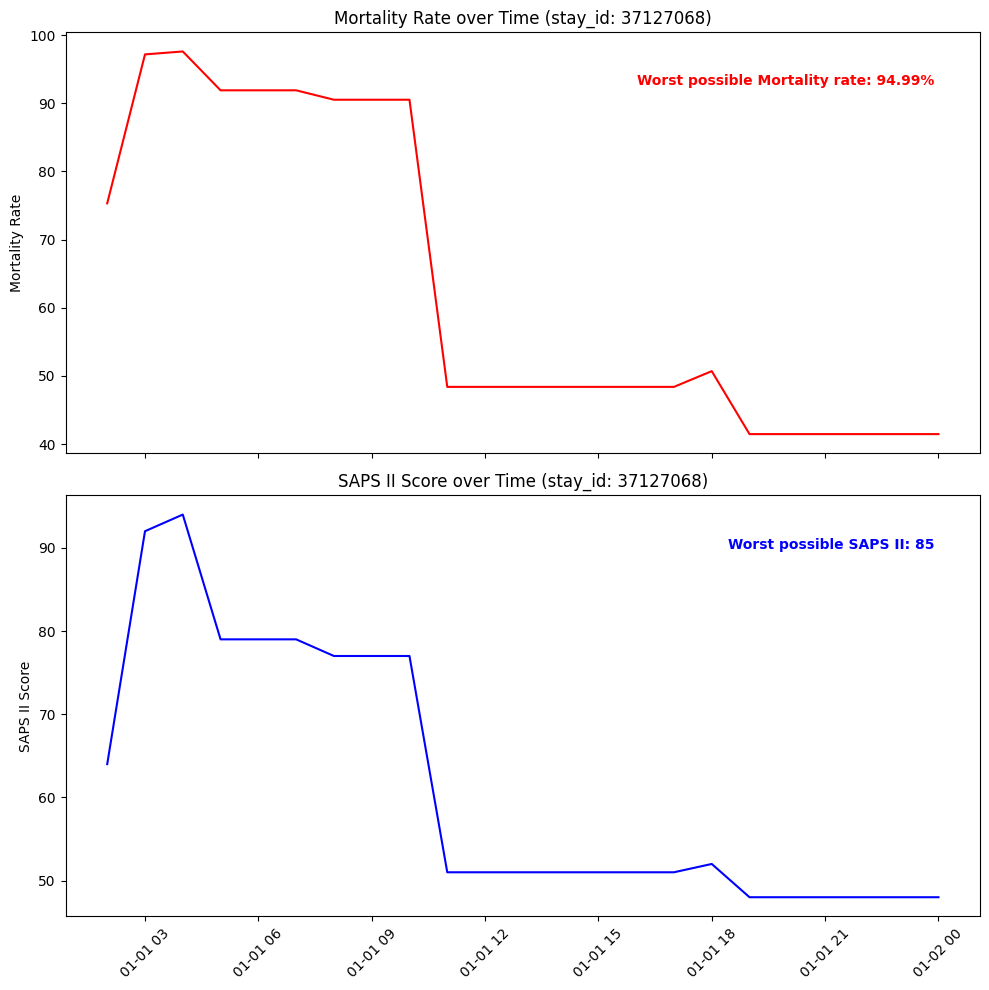

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1.plot(candidate_df['abs_event_time'], candidate_df['mortality_rate'], color='red')
ax1.set_ylabel('Mortality Rate')
ax1.set_title('Mortality Rate over Time (stay_id: {})'.format(candidate_stay_id))
ax1.text(0.95, 0.9, 'Worst possible Mortality rate: {:.2f}%'.format(worst_mortality), 
         transform=ax1.transAxes, ha='right', va='top', color='red', fontsize=10, weight='bold')

ax2.plot(candidate_df['abs_event_time'], candidate_df['saps_2_score'], color='blue')
ax2.set_ylabel('SAPS II Score')
ax2.set_title('SAPS II Score over Time (stay_id: {})'.format(candidate_stay_id))
ax2.text(0.95, 0.9, 'Worst possible SAPS II: {}'.format(worst_saps), 
         transform=ax2.transAxes, ha='right', va='top', color='blue', fontsize=10, weight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
cwd = os.getcwd()
svg_path = os.path.join(cwd, 'plot.svg')
plt.savefig(svg_path, format='svg')
plt.show()